In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset,DataLoader
import os

from sklearn.model_selection import KFold
from torch import nn
from torchsummary import summary
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


from torch.optim.lr_scheduler import StepLR
import pickle
from utils import * 

In [2]:
TARGET = "EDA"
with open('DICT_EDG300.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
dataX = loaded_data[TARGET]["dataX"]
dataY = loaded_data[TARGET]["dataY"]
len(dataX)

2760

In [3]:
len(dataX[0][0])

1200

In [4]:
# 十折交叉验证
kf = KFold(n_splits=5,shuffle=True,random_state=114514)
KFSORT = 0
INDEX   = []
for train_index, valid_index in kf.split(dataX):
    INDEX.append((train_index,valid_index))
    
# dataLoader_train = DataLoader(dataset_train, batch_size=32, shuffle=True,num_workers=4,pin_memory=True)
# dataLoader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=False,num_workers=4,pin_memory=True)

dataLoader_train = DataLoader(TensorDataset(dataX[INDEX[KFSORT][0]],dataY[INDEX[KFSORT][0]]), batch_size=128, shuffle=True,num_workers=4,pin_memory = True,prefetch_factor=8)
dataLoader_valid = DataLoader(TensorDataset(dataX[INDEX[KFSORT][1]],dataY[INDEX[KFSORT][1]]), batch_size=128, shuffle=False,num_workers=4,pin_memory = True,prefetch_factor=8)

dataCount = len(dataX[train_index])
dataCount

2208

In [5]:
 len(dataY[valid_index])

552

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
model = MODEL_CNN_EDA(input_channel=1)
model = model.to(device)

epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #0.0008

criterion = torch.nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=100, gamma=0.97)

lossHistory = []
accHistory = []
trainAccHis = []



early_stopping = EarlyStopping(patience=1200,filename="CNN_"+TARGET+"300_5("+str(KFSORT+1)+").pth")

for epoch in range(0,epochs):
    model.train()
    LOSS = 0
    ACC = 0
    for batch_data, batch_targets in dataLoader_train:
        optimizer.zero_grad()
        outputs = model(batch_data.to(device))
        loss = criterion(outputs, batch_targets.to(device))
        loss.backward()
        
        LOSS += loss.detach().cpu().numpy()
        ACC += (torch.max(outputs,dim=1)[1] == batch_targets.to(device)).sum()
        
        optimizer.step()
        
    scheduler.step()
    
    lossHistory.append(LOSS)
    
    print(f"epoch{epoch+1}: {str(LOSS)[0:7]}",end="\t ")
    cal = (ACC/dataCount).cpu()
    print(f"acc_t[{str(np.array(cal))[0:5]}]",end="\t ")
    trainAccHis.append(cal)
    print("lr["+str(optimizer.param_groups[0]['lr'])+"]",end="\t ")
    
#     for p in model.parameters():
#         print(p.grad.data)
    
    model.eval()
    with torch.no_grad():
        all_outputs = []
        all_targets = []
        for batch_data, batch_targets in dataLoader_valid:
            outputs = model(batch_data.to(device))
            _, predicted = torch.max(outputs.data, 1)
            all_outputs.append(predicted.cpu().numpy())
            all_targets.append(batch_targets.cpu().numpy())

        all_outputs = np.concatenate(all_outputs)
        all_targets = np.concatenate(all_targets)
        accuracy = accuracy_score(all_targets, all_outputs)
        accHistory.append(accuracy)
#         accAverHis.append(np.mean(np.array(accHistory)))
        print(f"acc_val: {str(accuracy)[0:7]}，",end="\t")
        print('OK '+'='*20 if(np.max(np.array(accHistory)) == accuracy) else str(100*(accuracy - np.max(np.array(accHistory))))[0:5],end="\t")
    
    
    if(epoch>50):
        print(f"[{ str(np.abs(np.mean(lossHistory)-np.mean(lossHistory[0:epoch-50])))[0:4] }")
#         if(np.abs(np.mean(lossHistory)-np.mean(lossHistory[0:epoch-50]))<0.05):
#             if(np.abs(100*(accuracy - np.max(np.array(accHistory))))<5):
#                 print("已提前结束。")
#                 break

                
    else:
        print("")
                    
    early_stopping(accuracy, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

epoch1: 19.7777	 acc_t[0.354]	 lr[0.0001]	 acc_val: 0.32427，	OK ====================	
epoch2: 19.8513	 acc_t[0.345]	 lr[0.0001]	 acc_val: 0.33514，	OK ====================	
epoch3: 19.7518	 acc_t[0.353]	 lr[0.0001]	 acc_val: 0.40760，	OK ====================	
epoch4: 19.6683	 acc_t[0.365]	 lr[0.0001]	 acc_val: 0.39855，	-0.90	
epoch5: 19.7156	 acc_t[0.378]	 lr[0.0001]	 acc_val: 0.39673，	-1.08	
epoch6: 19.6603	 acc_t[0.367]	 lr[0.0001]	 acc_val: 0.40217，	-0.54	
epoch7: 19.5989	 acc_t[0.369]	 lr[0.0001]	 acc_val: 0.39492，	-1.26	
epoch8: 19.7034	 acc_t[0.362]	 lr[0.0001]	 acc_val: 0.38949，	-1.81	
epoch9: 19.6478	 acc_t[0.376]	 lr[0.0001]	 acc_val: 0.38224，	-2.53	
epoch10: 19.6421	 acc_t[0.371]	 lr[0.0001]	 acc_val: 0.38949，	-1.81	
epoch11: 19.5773	 acc_t[0.372]	 lr[0.0001]	 acc_val: 0.40760，	OK ====================	
epoch12: 19.6035	 acc_t[0.381]	 lr[0.0001]	 acc_val: 0.44021，	OK ====================	
epoch13: 19.6551	 acc_t[0.362]	 lr[0.0001]	 acc_val: 0.41666，	-2.35	
epoch14: 19.5382	 acc_

epoch113: 17.5650	 acc_t[0.475]	 lr[9.7e-05]	 acc_val: 0.35869，	-12.8	[0.42
epoch114: 17.2699	 acc_t[0.506]	 lr[9.7e-05]	 acc_val: 0.46195，	-2.53	[0.43
epoch115: 17.6994	 acc_t[0.490]	 lr[9.7e-05]	 acc_val: 0.49456，	OK ====================	[0.43
epoch116: 17.3693	 acc_t[0.511]	 lr[9.7e-05]	 acc_val: 0.45471，	-3.98	[0.44
epoch117: 17.3539	 acc_t[0.499]	 lr[9.7e-05]	 acc_val: 0.47644，	-1.81	[0.44
epoch118: 17.2183	 acc_t[0.510]	 lr[9.7e-05]	 acc_val: 0.43478，	-5.97	[0.45
epoch119: 16.9871	 acc_t[0.518]	 lr[9.7e-05]	 acc_val: 0.38224，	-11.2	[0.46
epoch120: 17.4021	 acc_t[0.514]	 lr[9.7e-05]	 acc_val: 0.41485，	-7.97	[0.47
epoch121: 17.2515	 acc_t[0.517]	 lr[9.7e-05]	 acc_val: 0.47101，	-2.35	[0.47
epoch122: 16.9827	 acc_t[0.516]	 lr[9.7e-05]	 acc_val: 0.47644，	-1.81	[0.48
epoch123: 17.2181	 acc_t[0.503]	 lr[9.7e-05]	 acc_val: 0.46920，	-2.53	[0.49
epoch124: 17.5364	 acc_t[0.494]	 lr[9.7e-05]	 acc_val: 0.40579，	-8.87	[0.49
epoch125: 17.1382	 acc_t[0.520]	 lr[9.7e-05]	 acc_val: 0.47101，	-2.35	

epoch219: 10.4764	 acc_t[0.730]	 lr[9.409e-05]	 acc_val: 0.60869，	OK ====================	[1.31
epoch220: 10.6563	 acc_t[0.745]	 lr[9.409e-05]	 acc_val: 0.49094，	-11.7	[1.31
epoch221: 10.1342	 acc_t[0.750]	 lr[9.409e-05]	 acc_val: 0.57246，	-3.62	[1.32
epoch222: 10.3527	 acc_t[0.737]	 lr[9.409e-05]	 acc_val: 0.60507，	-0.36	[1.33
epoch223: 11.1195	 acc_t[0.726]	 lr[9.409e-05]	 acc_val: 0.53442，	-7.42	[1.34
epoch224: 10.9541	 acc_t[0.720]	 lr[9.409e-05]	 acc_val: 0.58876，	-1.99	[1.34
epoch225: 11.3555	 acc_t[0.736]	 lr[9.409e-05]	 acc_val: 0.54891，	-5.97	[1.34
epoch226: 10.7075	 acc_t[0.742]	 lr[9.409e-05]	 acc_val: 0.48550，	-12.3	[1.34
epoch227: 10.3213	 acc_t[0.729]	 lr[9.409e-05]	 acc_val: 0.53260，	-7.60	[1.35
epoch228: 10.5164	 acc_t[0.745]	 lr[9.409e-05]	 acc_val: 0.58333，	-2.53	[1.35
epoch229: 9.98839	 acc_t[0.755]	 lr[9.409e-05]	 acc_val: 0.52717，	-8.15	[1.35
epoch230: 10.3845	 acc_t[0.735]	 lr[9.409e-05]	 acc_val: 0.51811，	-9.05	[1.35
epoch231: 9.77307	 acc_t[0.741]	 lr[9.409e-05]

epoch322: 6.49016	 acc_t[0.855]	 lr[9.12673e-05]	 acc_val: 0.62681，	-2.53	[1.17
epoch323: 6.85454	 acc_t[0.832]	 lr[9.12673e-05]	 acc_val: 0.59782，	-5.43	[1.17
epoch324: 7.11512	 acc_t[0.833]	 lr[9.12673e-05]	 acc_val: 0.51449，	-13.7	[1.16
epoch325: 7.00864	 acc_t[0.841]	 lr[9.12673e-05]	 acc_val: 0.53260，	-11.9	[1.16
epoch326: 6.27139	 acc_t[0.860]	 lr[9.12673e-05]	 acc_val: 0.48550，	-16.6	[1.16
epoch327: 6.80617	 acc_t[0.853]	 lr[9.12673e-05]	 acc_val: 0.52536，	-12.6	[1.16
epoch328: 6.33711	 acc_t[0.851]	 lr[9.12673e-05]	 acc_val: 0.60326，	-4.89	[1.16
epoch329: 6.36115	 acc_t[0.843]	 lr[9.12673e-05]	 acc_val: 0.49637，	-15.5	[1.16
epoch330: 6.52873	 acc_t[0.853]	 lr[9.12673e-05]	 acc_val: 0.63043，	-2.17	[1.16
epoch331: 7.35453	 acc_t[0.836]	 lr[9.12673e-05]	 acc_val: 0.60326，	-4.89	[1.15
epoch332: 6.69382	 acc_t[0.848]	 lr[9.12673e-05]	 acc_val: 0.56884，	-8.33	[1.15
epoch333: 6.42230	 acc_t[0.852]	 lr[9.12673e-05]	 acc_val: 0.55434，	-9.78	[1.15
epoch334: 6.34623	 acc_t[0.864]	 lr[9.12

epoch424: 4.02238	 acc_t[0.924]	 lr[8.8529281e-05]	 acc_val: 0.50181，	-18.1	[1.10
epoch425: 3.81343	 acc_t[0.935]	 lr[8.8529281e-05]	 acc_val: 0.60507，	-7.78	[1.10
epoch426: 4.07072	 acc_t[0.940]	 lr[8.8529281e-05]	 acc_val: 0.54710，	-13.5	[1.10
epoch427: 3.40669	 acc_t[0.943]	 lr[8.8529281e-05]	 acc_val: 0.56702，	-11.5	[1.09
epoch428: 2.62253	 acc_t[0.960]	 lr[8.8529281e-05]	 acc_val: 0.60326，	-7.97	[1.09
epoch429: 2.34098	 acc_t[0.953]	 lr[8.8529281e-05]	 acc_val: 0.59601，	-8.69	[1.09
epoch430: 2.56934	 acc_t[0.955]	 lr[8.8529281e-05]	 acc_val: 0.66123，	-2.17	[1.09
epoch431: 2.65867	 acc_t[0.956]	 lr[8.8529281e-05]	 acc_val: 0.52355，	-15.9	[1.10
epoch432: 2.77399	 acc_t[0.944]	 lr[8.8529281e-05]	 acc_val: 0.61413，	-6.88	[1.10
epoch433: 2.30455	 acc_t[0.956]	 lr[8.8529281e-05]	 acc_val: 0.65398，	-2.89	[1.10
epoch434: 2.00612	 acc_t[0.961]	 lr[8.8529281e-05]	 acc_val: 0.60688，	-7.60	[1.10
epoch435: 2.07211	 acc_t[0.963]	 lr[8.8529281e-05]	 acc_val: 0.67753，	-0.54	[1.10
epoch436: 2.8702

In [8]:

# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:582"

findfont: Font family ['HGSS_CNKI'] not found. Falling back to DejaVu Sans.


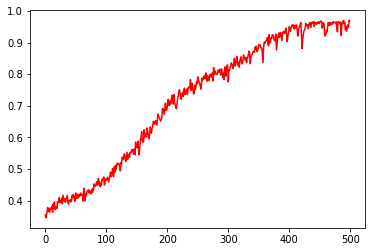

In [9]:
# 0 43
# 60 42



x = range(0,epochs) # x轴坐标值113  0.00009 -> 81
plt.plot(trainAccHis,c = 'r') # 参数c为color简写，表示颜色,r为red即红色

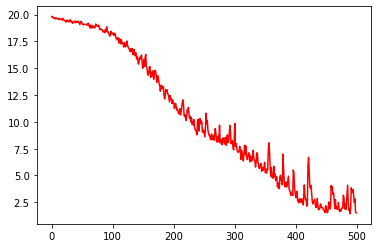

In [10]:
x = range(0,epochs) # x轴坐标值
plt.plot(lossHistory,c = 'r') # 参数c为color简写，表示颜色,r为red即红色

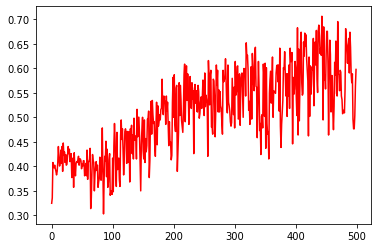

In [11]:

x = range(0,epochs) # x轴坐标值
plt.plot(accHistory,c = 'r') # 参数c为color简写，表示颜色,r为red即红色


In [12]:

with open("loss_CNN_"+TARGET+"300_5("+str(KFSORT+1)+").pkl", 'wb') as file:
    pickle.dump(dict({"loss":lossHistory,"acc":accHistory,"trainAccHis":trainAccHis}), file)

In [13]:
STOP

NameError: name 'STOP' is not defined